# Pipeline for High-z Radio Galaxies 08: Radio detection classification

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").  

This time, being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

***

## Reading data

In [13]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [14]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [15]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [16]:
mqc_version = '7_4d'  # '7_2'

In [17]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [18]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [19]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [20]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [21]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [22]:
# full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [23]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and {n_is_gal:,} are identified as galaxies.')

In this dataset, with 6,729,647 elements,
30,395 of them are marked as AGN, and 55,153 are identified as galaxies.


---

## Possible correlations

In [24]:
print(full_catalog_df.columns.to_list())

['band_num', 'radio_detect', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [25]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [26]:
# full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [27]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal'])

---

#### Add prediction from first AGN/galaxy model as feature.

In [28]:
AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

Transformation Pipeline and Model Successfully Loaded


In [29]:
AGN_pred_threshold = 0.5
full_catalog_df    = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=AGN_pred_threshold, raw_score=False).drop(columns=['Score'])

In [30]:
full_catalog_df = full_catalog_df.rename(columns={'Label': 'class'})

---

## Split data: Test, Train, Validation

In [31]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
     random_state=seed, stratify=full_catalog_df.loc[:, 'radio_detect'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (6729647, 42)
Data for Modeling (Train and Test): (5383717, 42)
Unseen Data For Validation: (1345930, 42)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [32]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [33]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [34]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [35]:
rsd_vals

radio_detect    429.862029
w1_w2           297.156642
class           247.058603
r_i             156.669831
g_r             151.673935
g_i             107.396609
i_z              90.812082
z_y              87.002552
band_num         63.618623
J_H              22.284743
H_K              21.546643
w2_w3            17.361675
FUVmag            8.097781
imag              7.544170
i/K               7.505645
zmag              7.473208
W2mproPM          7.371029
rmag              6.929599
W1mag             6.535327
z/W1              6.306661
w1/w4             6.028430
gmag              6.009246
ymag              5.949056
w1/w3             5.885310
w3_w4             5.769522
r/H               5.755897
Jmag              5.644119
y/W2              5.499800
W2mag             5.490297
FUV/K             5.213395
g/J               4.985980
W1mproPM          4.681020
i/y               4.587361
Hmag              4.574217
W4mag             4.519206
r/z               4.064898
J/K               3.908499
w

In [36]:
correlation = norm_train_test_df.corr()

In [37]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [38]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [39]:
target_feat = 'radio_detect'

In [40]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [41]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [42]:
list_drop_corr

['W1mproPM',
 'w2/w4',
 'Hmag',
 'w1/w3',
 'i/K',
 'FUV_NUV',
 'Kmag',
 'W2mproPM',
 'J/K',
 'r/H',
 'zmag',
 'W3mag',
 'W2mag',
 'g/J',
 'rmag',
 'w1/w4',
 'y/W2',
 'FUV/K',
 'W1mag',
 'ymag',
 'gmag',
 'Jmag',
 'imag',
 'w2_w3',
 'i/y']

In [43]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [44]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [45]:
corr_discard = norm_train_test_discard.corr()

In [46]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
g_r       g_i         0.742111
g_i       r_i         0.690243
band_num  w1_w2       0.674940
z/W1      band_num    0.627275
r_i       r/z         0.624688
z/W1      z_y         0.594883
g_i       band_num    0.565718
          i_z         0.510208
band_num  z_y         0.504529
g_i       w1_w2       0.502688
H_K       J_H         0.500821
g_r       band_num    0.474295
g_i       z_y         0.466401
          z/W1        0.457523
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

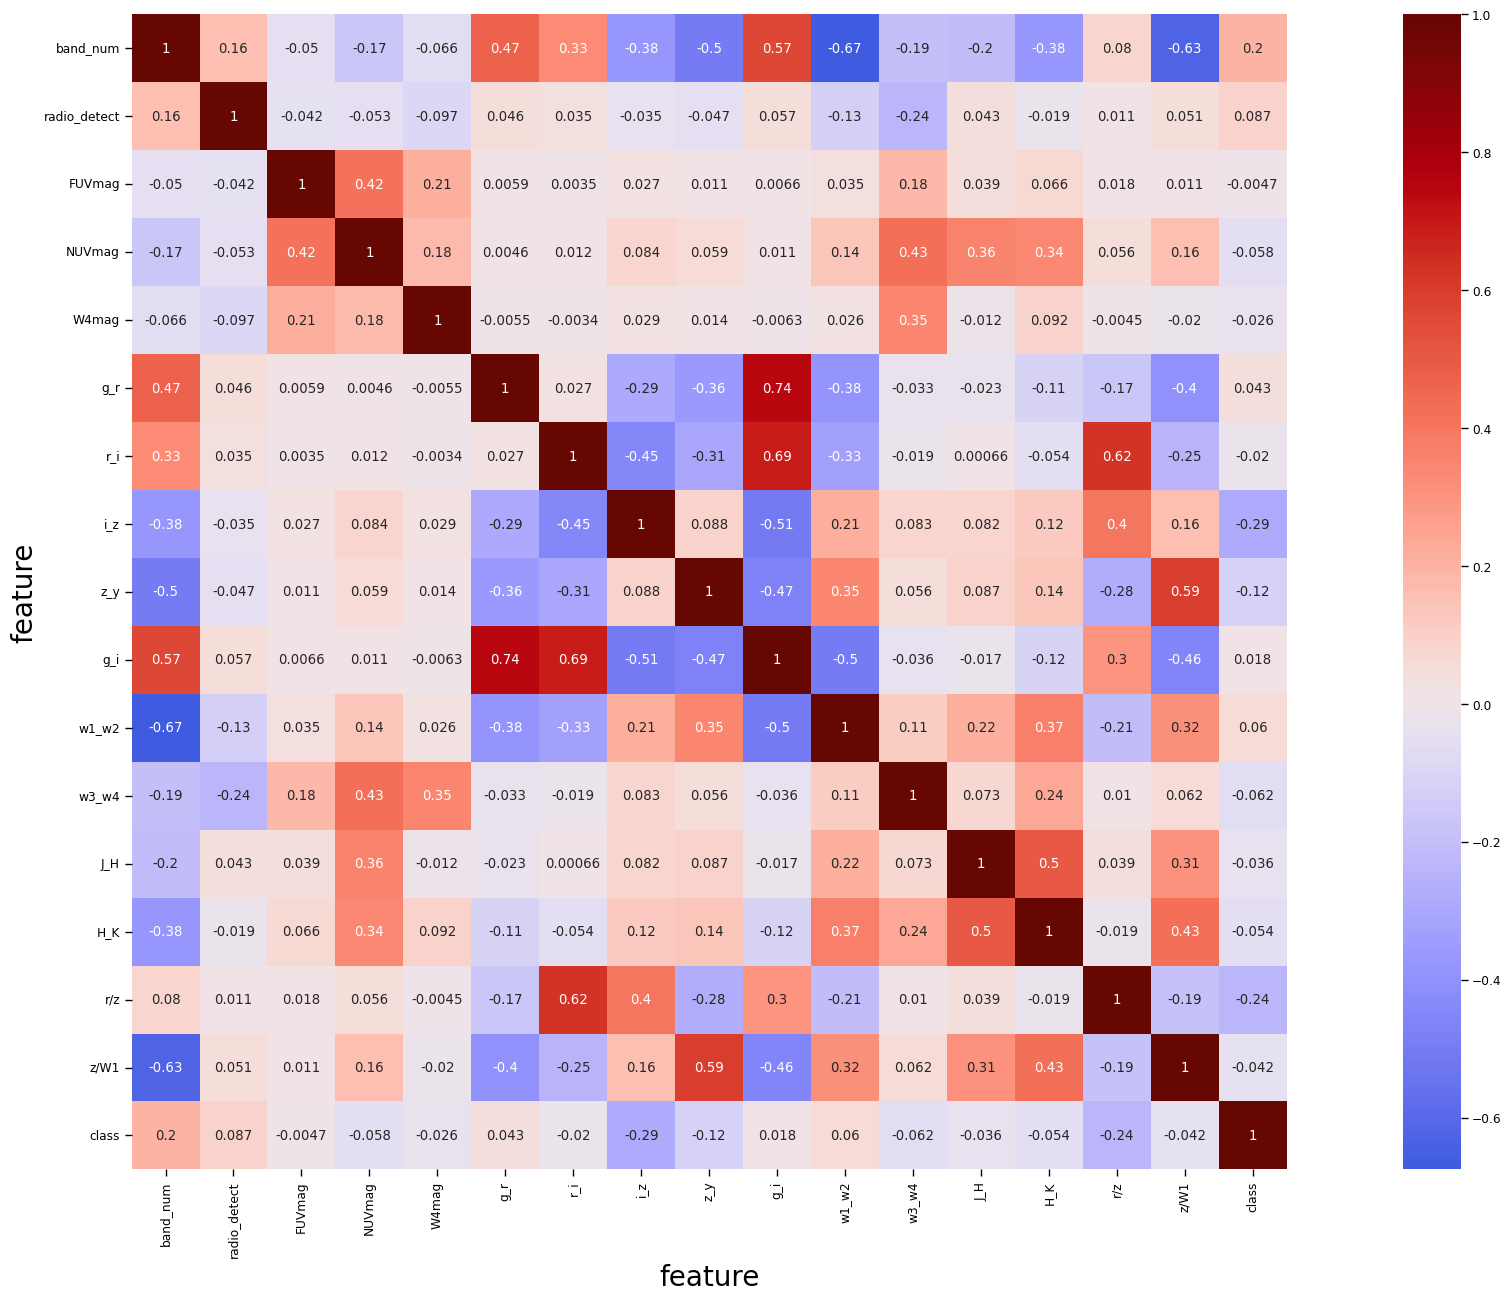

In [47]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [48]:
norm_train_test_discard.loc[:, 'radio_detect'] = norm_train_test_discard.loc[:, 'radio_detect'].astype(bool)

In [49]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [50]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
FUVmag    FUVmag      1.000000
NUVmag    FUVmag      0.661442
r_i       g_i         0.566660
band_num  g_i         0.498514
i_z       g_i         0.469494
r/z       g_i         0.461391
J_H       H_K         0.396863
g_r       g_i         0.378323
band_num  i_z         0.367104
          z/W1        0.362261
r/z       r_i         0.359938
z/W1      z_y         0.350889
band_num  z_y         0.348367
r/z       i_z         0.333347
i_z       z_y         0.329171
z/W1      band_num    0.320947
r/z       z_y         0.304116
z_y       g_i         0.300265
          band_num    0.291626
z/W1      w1_w2       0.289465
dtype: float64

In [51]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [52]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [53]:
target_feat = 'radio_detect'

In [54]:
list_drop_pps = []

In [55]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [56]:
list_drop_pps

[]

In [57]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [58]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'radio_detect', random_seed=seed)

In [59]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w3_w4,radio_detect,1.895892e-01,classification,True,weighted F1,0.917101,0.932818,DecisionTreeClassifier()
1,band_num,radio_detect,6.314068e-02,classification,True,weighted F1,0.917101,0.922335,DecisionTreeClassifier()
2,FUVmag,radio_detect,5.634416e-02,classification,True,weighted F1,0.917101,0.921772,DecisionTreeClassifier()
3,W4mag,radio_detect,5.384599e-02,classification,True,weighted F1,0.917101,0.921565,DecisionTreeClassifier()
4,NUVmag,radio_detect,5.086069e-02,classification,True,weighted F1,0.917101,0.921317,DecisionTreeClassifier()
5,H_K,radio_detect,3.704137e-03,classification,True,weighted F1,0.917101,0.917408,DecisionTreeClassifier()
6,class,radio_detect,3.938660e-07,classification,True,weighted F1,0.917101,0.917101,DecisionTreeClassifier()
7,g_r,radio_detect,0.000000e+00,classification,True,weighted F1,0.917101,0.909938,DecisionTreeClassifier()
8,r_i,radio_detect,0.000000e+00,classification,True,weighted F1,0.917101,0.904771,DecisionTreeClassifier()
9,i_z,radio_detect,0.000000e+00,classification,True,weighted F1,0.917101,0.906199,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [60]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [61]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [62]:
exp_radio = pyc.setup(data=train_test_df, target='radio_detect', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu='force')  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,radio_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5383717, 42)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [63]:
pyc.get_config('X').columns

Index(['band_num', 'FUVmag', 'NUVmag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y',
       'g_i', 'w1_w2', 'w3_w4', 'J_H', 'H_K', 'r/z', 'z/W1', 'class'],
      dtype='object')

In [64]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,cuml.linear_model.logistic_regression.Logistic...,True
knn,K Neighbors Classifier,cuml.neighbors.kneighbors_classifier.KNeighbor...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,cuml.linear_model.mbsgd_classifier.MBSGDClassi...,True
rbfsvm,SVM - Radial Kernel,pycaret.internal.cuml_wrappers.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,cuml.linear_model.ridge.Ridge,True


In [65]:
models_clf_gpu       = ['catboost', 'xgboost', 'lightgbm', 'dummy', 'lr', 'knn', 'ridge', 'rf']  # knn too slow, ridge does not work
final_selection_clf  = ['catboost', 'rf', 'lightgbm', 'et', 'gbc', 'dummy']
n_models             = 5
# top_model_radio      = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort='MCC')  # 1:15 hour for used_models_clf
top_model_radio      = pyc.compare_models(n_select=n_models, include=models_clf_gpu, sort='MCC')  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9554,0.8343,0.2081,0.7327,0.3241,0.3084,0.3755,3.1410
catboost,CatBoost Classifier,0.9555,0.8288,0.1992,0.7485,0.3147,0.2995,0.3718,24.7600
lightgbm,Light Gradient Boosting Machine,0.9554,0.8322,0.2016,0.7402,0.3169,0.3016,0.3717,6.8840
rf,Random Forest Classifier,0.9539,0.8289,0.1409,0.7847,0.2388,0.2268,0.3205,21.7710
knn,K Neighbors Classifier,0.9185,0.7133,0.2388,0.5305,0.3033,0.2762,0.3092,55.1790
lr,Logistic Regression,0.9534,0.7937,0.1369,0.7538,0.2318,0.2194,0.3088,1.4690
ridge,Ridge Classifier,0.9506,0.0000,0.0561,0.7599,0.1044,0.0980,0.1977,1.5440
dummy,Dummy Classifier,0.9487,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9530


Thus, we select `xgboost` as meta learner.

Thus, we stack the models.

In [58]:
stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[1:], meta_model=top_model_radio[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7729,0.7782,0.3964,0.7389,0.5160,0.3848,0.4166
1,0.7729,0.7794,0.4074,0.7295,0.5228,0.3891,0.4176
2,0.7664,0.7725,0.4033,0.7057,0.5133,0.3743,0.3997
3,0.7692,0.7801,0.3978,0.7212,0.5128,0.3777,0.4064
4,0.7823,0.7856,0.4388,0.7431,0.5518,0.4203,0.4458
5,0.7810,0.7835,0.4179,0.7553,0.5381,0.4098,0.4406
6,0.7735,0.7781,0.4070,0.7319,0.5231,0.3900,0.4189
7,0.7835,0.7927,0.4337,0.7521,0.5501,0.4208,0.4485
8,0.7785,0.7740,0.4337,0.7313,0.5444,0.4105,0.4349


In [59]:
tuned_radio_clf = pyc.tune_model(stacked_model_radio, early_stopping='asha', optimize='MCC',\
                               search_library='tune-sklearn', search_algorithm='random')  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7723,0.7789,0.3855,0.7460,0.5083,0.3792,0.4142
1,0.7740,0.7783,0.4108,0.7311,0.5260,0.3926,0.4207
2,0.7623,0.7722,0.3828,0.7035,0.4958,0.3575,0.3859
3,0.7717,0.7844,0.3978,0.7321,0.5155,0.3828,0.4133
4,0.7831,0.7842,0.4327,0.7518,0.5492,0.4198,0.4476
5,0.7831,0.7849,0.4090,0.7736,0.5351,0.4107,0.4462
6,0.7710,0.7774,0.3926,0.7331,0.5114,0.3792,0.4107
7,0.7854,0.7938,0.4234,0.7699,0.5463,0.4209,0.4532
8,0.7810,0.7729,0.4316,0.7432,0.5461,0.4149,0.4415


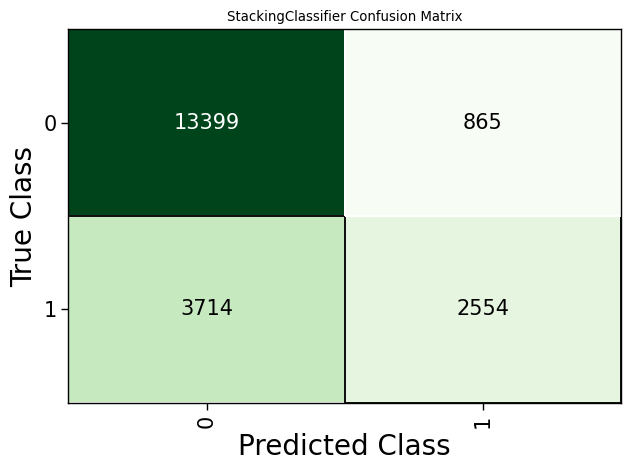

In [60]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

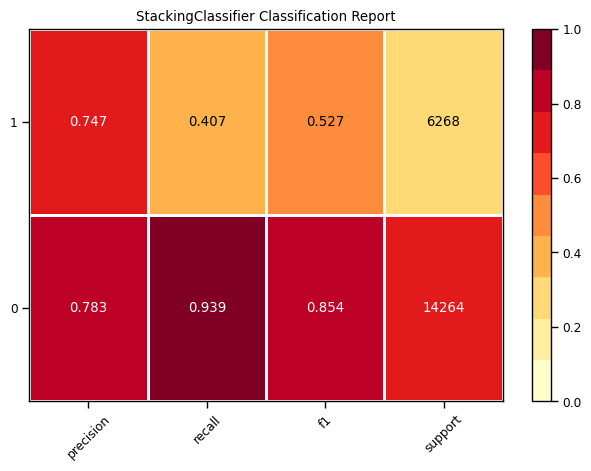

In [61]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

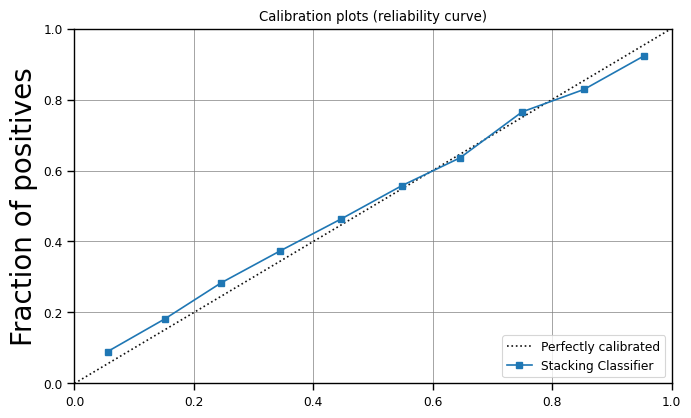

In [62]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

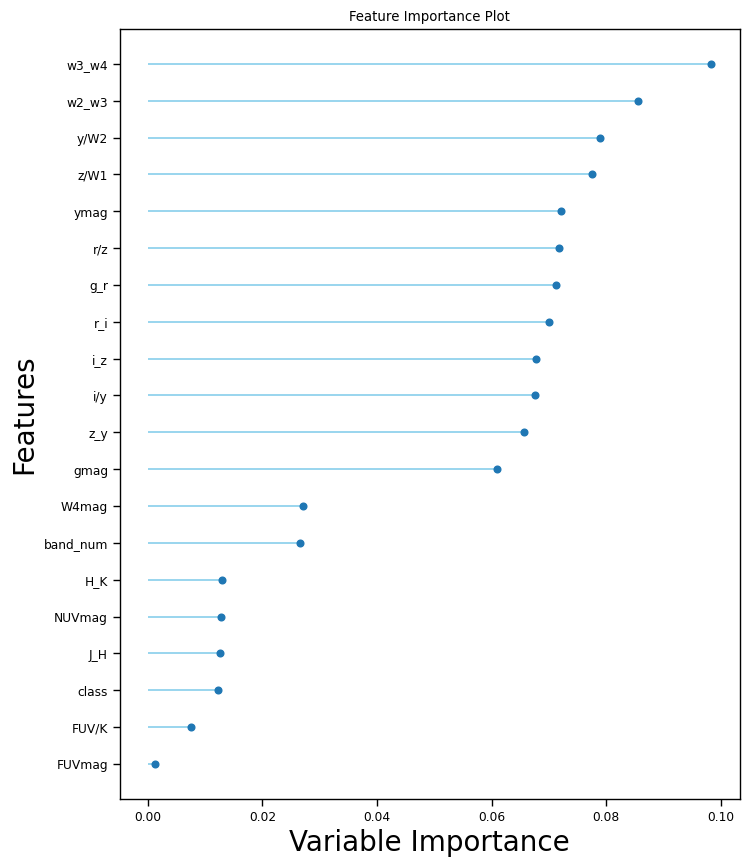

In [63]:
pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [64]:
pyc.plot_model(tuned_radio_clf, plot='parameter')

,Parameters
cv,5
estimators,"[('rf', RandomForestClassifier(bootstrap=True,..."
final_estimator,<catboost.core.CatBoostClassifier object at 0x...
n_jobs,12
passthrough,True
stack_method,auto
verbose,0


In [65]:
plt.rcParams.update(plt.rcParamsDefault)

In [66]:
pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7770,0.7861,0.4075,0.7470,0.5273,0.3975,0.4287


,band_num,gmag,ymag,FUVmag,NUVmag,W4mag,g_r,r_i,i_z,z_y,...,r/z,i/y,FUV/K,z/W1,y/W2,class,radio_detect,Label,Score_0,Score_1
0,-0.892022,1.385970,0.032784,0.158855,0.360930,0.207439,-0.903587,-0.712753,6.209622,0.317161,...,3.165649,4.731407,-0.068386,-1.477147,-1.054675,-0.742198,0,0,0.8045,0.1955
1,-0.089456,-0.761657,-0.477720,0.158855,0.360930,0.207439,-0.596652,-0.615677,0.743635,-0.126396,...,0.043050,0.570433,-0.068386,0.069571,0.128550,1.347349,0,1,0.4771,0.5229
2,-2.046501,-0.141589,1.596941,0.158855,0.360930,0.207439,-1.319433,-0.149212,-0.820294,-0.760982,...,-0.807047,-1.400629,-0.068386,0.864818,2.005670,1.347349,1,0,0.7616,0.2384
3,1.191526,-0.151279,-0.774613,0.158855,0.360930,0.207439,0.926265,0.191389,-0.083270,0.165492,...,0.170965,0.128650,-0.068386,-0.160654,-0.595148,-0.742198,0,0,0.7182,0.2818
4,-0.089456,-0.043633,-0.591165,0.158855,0.360930,0.207439,0.932224,0.077879,0.188983,-0.120372,...,0.264120,0.104443,-0.068386,-0.071179,-0.361495,-0.742198,0,0,0.7411,0.2589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,-0.495205,0.035567,1.596941,0.158855,0.360930,0.207439,-0.592534,-0.968633,0.201878,-1.425681,...,-0.720402,-1.043605,-0.068386,0.638391,1.336563,1.347349,0,0,0.8607,0.1393
20528,2.081796,-1.466056,-1.442972,-6.323858,-2.848336,-4.870494,-0.560571,-0.305805,-0.085433,0.200569,...,-0.257258,0.206577,-2.000327,0.583312,0.712800,1.347349,1,1,0.1260,0.8740
20529,-0.495205,0.252443,1.596941,0.158855,0.360930,0.207439,-0.344992,0.289274,0.750507,-3.327415,...,0.766904,-2.115196,-0.068386,0.649690,1.916438,-0.742198,0,0,0.6959,0.3041
20530,-0.892022,0.568142,1.596941,0.158855,0.360930,0.207439,-0.393755,-0.671837,-1.618295,1.317041,...,-1.870225,-0.349751,-0.068386,1.253047,0.866748,1.347349,0,0,0.7873,0.2127


In [67]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7770,0.7861,0.4075,0.7470,0.5273,0.3975,0.4287


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [68]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

In [70]:
if save_model_flag:
    pyc.save_model(final_radio_clf, 'models/classification_radio_detect_may_04_2022')  # Model (it will be saved with .pkl extension)
    # pyc.save_config('../../models/config_classification_radio_detect_apr_27_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    final_radio_clf = pyc.load_model('models/classification_radio_detect_may_04_2022')

### Prediction process

#### Feature importances

In [71]:
extended_data_radio = validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)].copy()
extended_idx_radio  = extended_data_radio.index
initial_cols_radio  = extended_data_radio.columns
extended_cols_radio = extended_data_radio.columns.insert(0, 'rf')
extended_cols_radio = extended_cols_radio.insert(0, 'lightgbm')
extended_cols_radio = extended_cols_radio.insert(0, 'et')
extended_cols_radio = extended_cols_radio.insert(0, 'gbc')

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [72]:
print('Running data pre-processing:\n')
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_radio_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_radio = method.transform(extended_data_radio)
extended_data_radio_df = pd.DataFrame(extended_data_radio, columns=extended_cols_radio, index=extended_idx_radio)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [73]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_radio_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_radio_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_radio, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_radio))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [74]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_radio_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_radio_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_radio_clf.estimators
    estimators_list_ = final_radio_clf.estimators_

In [75]:
base_models_names = [model[0] for model in estimators_list]

In [76]:
coef_sorted_base_df = {}

In [77]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                     'Importance': np.abs(model_fit.coef_) *\
                                     extended_data_radio_df.loc[:, extended_cols_radio.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [78]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [79]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for rf...
Calculating for lightgbm...
Calculating for et...
Calculating for gbc...


rf             lightgbm                   et                  gbc  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      w3_w4   9.817994      z/W1   9.366667     w2_w3   8.414409     w3_w4   
1      w2_w3   8.511020       g_r   8.833333     w3_w4   7.631050     w2_w3   
2       z/W1   7.843291     w2_w3   8.066667      z/W1   7.545137     class   
3       y/W2   7.682825       r/z   7.733333      y/W2   7.417825      y/W2   
4        r/z   7.207598       r_i   7.166667      ymag   7.144442      z/W1   
5       ymag   7.186430      y/W2   6.700000       r/z   6.950176      gmag   
6        g_r   7.160191      gmag   6.433333       r_i   6.936281       r/z   
7        r_i   7.095171       i_z   6.100000       g_r   6.764996     W4mag   
8        i_z   6.799828      ymag   5.500000       i/y   6.738899       g_r   
9        i/y   6.788237       z_y   5.333333       i_z   6.689677      ymag   
10       z_y   6.517528       i/y   5.133333       z_y   6.488406       r_i   
11      gmag   6.191688     w3_w4   5.100000      gmag   6.032958    NUVmag   
12  band_num   2.812744     class   3.233333     W4mag   4.463604  band_num   
13     W4mag   2.605120     FUV/K   2.966667  band_num   3.830404       H_K   
14       H_K   1.396354  band_num   2.966667    NUVmag   2.058111     FUV/K   
15       J_H   1.257464       J_H   2.633333       H_K   1.312278       J_H   
16     class   1.141799       H_K   2.466667       J_H   1.253916       i/y   
17    NUVmag   1.101777    NUVmag   2.200000     class   1.022891       i_z   
18     FUV/K   0.758935     W4mag   1.966667     FUV/K   0.921152       z_y   
19    FUVmag   0.124008    FUVmag   0.100000    FUVmag   0.383388    FUVmag   

               
   Importance  
0   65.457246  
1   10.356577  
2    4.215923  
3    3.252050  
4    2.774730  
5    2.511717  
6    2.354462  
7    2.146098  
8    2.123602  
9    1.716208  
10   0.597225  
11   0.458696  
12   0.423053  
13   0.387299  
14   0.326566  
15   0.285172  
16   0.263641  
17   0.243402  
18   0.106332  
19   0.000000

In [80]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,et,36.684741
1,gbc,22.395324
2,lightgbm,14.516023
3,rf,8.705888
4,y/W2,2.915276
5,z/W1,2.478616
6,class,2.346216
7,w2_w3,1.720440
8,band_num,1.587791
9,ymag,1.210553


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
z/W1	9.363
g_r	8.830
w2_w3	8.068
r/z	7.731
r_i	7.164
y/W2	6.699
gmag	6.432
i_z	6.098
ymag	5.500
z_y	5.332
i/y	5.133
w3_w4	5.123
class	3.232
band_num	2.966
FUV/K	2.964
J_H	2.632
H_K	2.465
NUVmag	2.199
W4mag	1.968
FUVmag	0.100


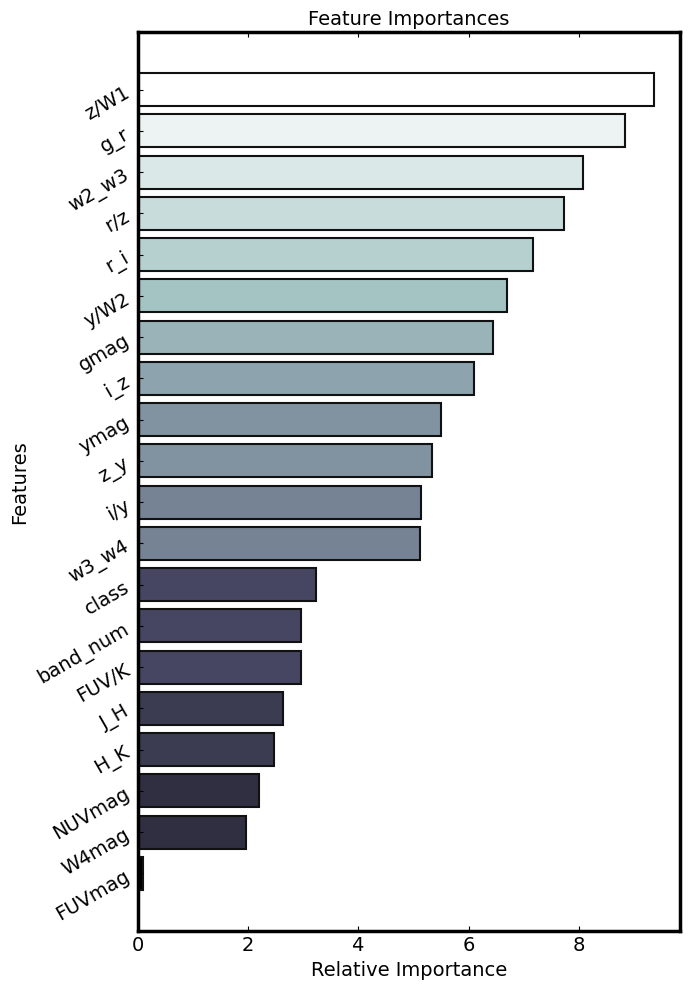

In [118]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_radio_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_radio_detect_02.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [119]:
radio_pred_threshold = 0.5
# radio_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [120]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7812,0.7891,0.4209,0.7536,0.5402,0.4113,0.4414


Create confusion matrix with validation data.

In [121]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

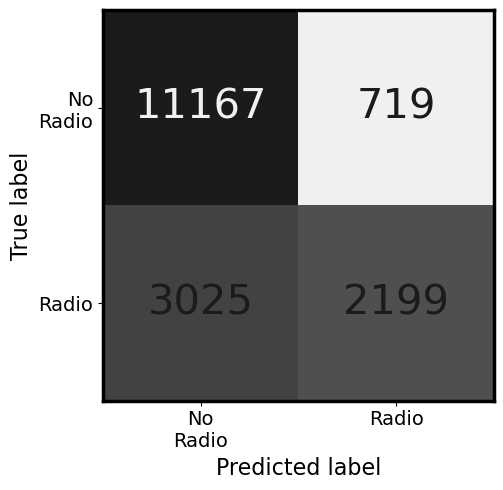

In [122]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_radio_detect_02.pdf', bbox_inches='tight')
plt.show()

In [123]:
# TN_radio, FP_radio, FN_radio, TP_radio = cm_mat_val.flatten().astype('float32')

In [124]:
MCC_radio_val    = MCC_from_CM(cm_mat_val)
ACC_radio_val    = ACC_from_CM(cm_mat_val)
F1_radio_val     = F1_from_CM(cm_mat_val)
Recall_radio_val = Recall_from_CM(cm_mat_val)

In [125]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_val:.4f}')
print(f'F1-score is                          F1 = {F1_radio_val:.4f}')
print(f'Recall is                           TPR = {Recall_radio_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.4414
Accuracy is                         ACC = 0.7812
F1-score is                          F1 = 0.5402
Recall is                           TPR = 0.4209


---

### Separate AGN and galaxies for Confusion Matrices

In [126]:
validation_prediction_clf_AGN = validation_prediction_clf.loc[validation_prediction_clf.loc[:, 'class'] == 1]
validation_prediction_clf_gal = validation_prediction_clf.loc[validation_prediction_clf.loc[:, 'class'] == 0]

In [127]:
cm_mat_val_gal = np.array([[np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 0) & np.array(validation_prediction_clf_gal['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 0) & np.array(validation_prediction_clf_gal['Label'] == 1))],\
        [np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 1) & np.array(validation_prediction_clf_gal['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf_gal['radio_detect'] == 1) & np.array(validation_prediction_clf_gal['Label'] == 1))]])

cm_mat_val_AGN = np.array([[np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 0) & np.array(validation_prediction_clf_AGN['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 0) & np.array(validation_prediction_clf_AGN['Label'] == 1))],\
        [np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 1) & np.array(validation_prediction_clf_AGN['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf_AGN['radio_detect'] == 1) & np.array(validation_prediction_clf_AGN['Label'] == 1))]])

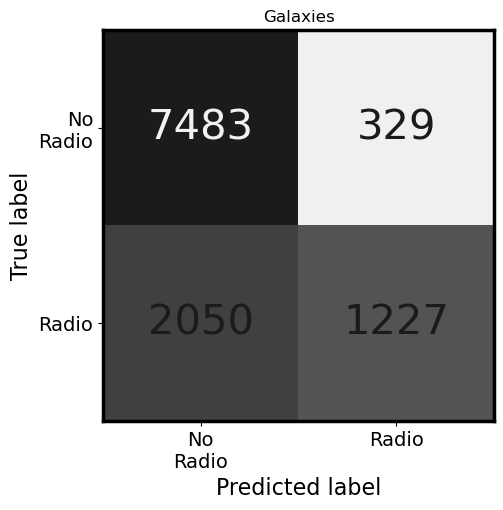

In [128]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_val_gal, title='Validation set - Galaxies', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_radio_detect_gal_02.pdf', bbox_inches='tight')
plt.show()

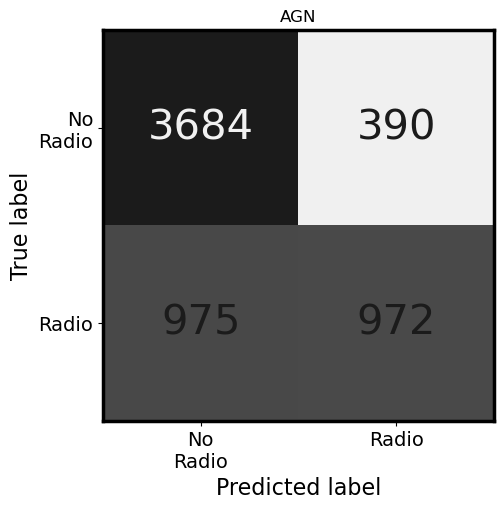

In [129]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_val_AGN, title='Validation set - AGN', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_radio_detect_AGN_02.pdf', bbox_inches='tight')
plt.show()

In [130]:
# TN_radio_gal, FP_radio_gal, FN_radio_gal, TP_radio_gal = cm_mat_val_gal.flatten().astype('float32')
# TN_radio_AGN, FP_radio_AGN, FN_radio_AGN, TP_radio_AGN = cm_mat_val_AGN.flatten().astype('float32')

In [131]:
MCC_radio_val_gal    = MCC_from_CM(cm_mat_val_gal)
ACC_radio_val_gal    = ACC_from_CM(cm_mat_val_gal)
F1_radio_val_gal     = F1_from_CM(cm_mat_val_gal)
Recall_radio_val_gal = Recall_from_CM(cm_mat_val_gal)

In [132]:
MCC_radio_val_AGN    = MCC_from_CM(cm_mat_val_AGN)
ACC_radio_val_AGN    = ACC_from_CM(cm_mat_val_AGN)
F1_radio_val_AGN     = F1_from_CM(cm_mat_val_AGN)
Recall_radio_val_AGN = Recall_from_CM(cm_mat_val_AGN)

In [133]:
print('Metrics for galaxies in validation set:')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val_gal:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_val_gal:.4f}')
print(f'F1-score is                          F1 = {F1_radio_val_gal:.4f}')
print(f'Recall is                           TPR = {Recall_radio_val_gal:.4f}')

Metrics for galaxies in validation set:
Matthews Correlation Coefficient is MCC = 0.4366
Accuracy is                         ACC = 0.7855
F1-score is                          F1 = 0.5078
Recall is                           TPR = 0.3744


In [134]:
print('Metrics for AGN in validation set:')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val_AGN:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_val_AGN:.4f}')
print(f'F1-score is                          F1 = {F1_radio_val_AGN:.4f}')
print(f'Recall is                           TPR = {Recall_radio_val_AGN:.4f}')

Metrics for AGN in validation set:
Matthews Correlation Coefficient is MCC = 0.4511
Accuracy is                         ACC = 0.7733
F1-score is                          F1 = 0.5875
Recall is                           TPR = 0.4992


---

In [135]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['radio_detect']), train_test_df.loc[:, 'radio_detect'], False, 'radio_detect'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['radio_detect']),
                train_test_df.loc[:, 'radio_detect'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [136]:
train_prediction_clf = pyc.predict_model(final_radio_clf, data=train_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9600,0.9951,0.8923,0.9742,0.9315,0.9033,0.9051


In [137]:
test_prediction_clf = pyc.predict_model(final_radio_clf, data=test_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9585,0.9948,0.8887,0.9741,0.9295,0.9002,0.9021


In [138]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [139]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

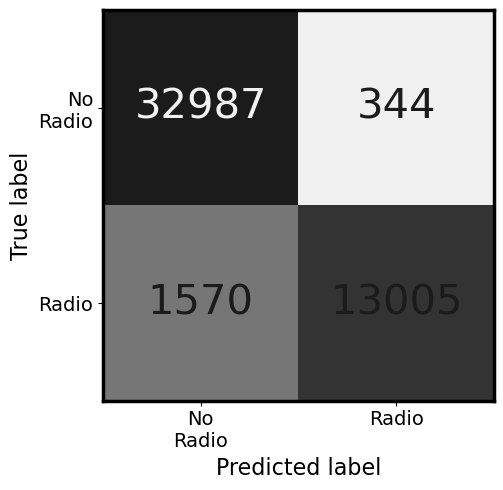

In [140]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_radio_detect_02.pdf', bbox_inches='tight')
plt.show()

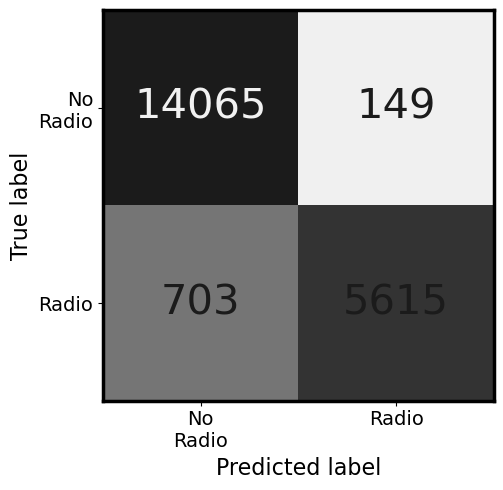

In [141]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_radio_detect_02.pdf', bbox_inches='tight')
plt.show()

In [142]:
# TN_radio_train, FP_radio_train, FN_radio_train, TP_radio_train = cm_mat_train.flatten().astype('float32')

In [143]:
MCC_radio_train    = MCC_from_CM(cm_mat_train)
ACC_radio_train    = ACC_from_CM(cm_mat_train)
F1_radio_train     = F1_from_CM(cm_mat_train)
Recall_radio_train = Recall_from_CM(cm_mat_train)

In [144]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_train:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_train:.4f}')
print(f'F1-score is                          F1 = {F1_radio_train:.4f}')
print(f'Recall is                           TPR = {Recall_radio_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.9051
Accuracy is                         ACC = 0.9600
F1-score is                          F1 = 0.9315
Recall is                           TPR = 0.8923


In [145]:
# TN_radio_test, FP_radio_test, FN_radio_test, TP_radio_test = cm_mat_test.flatten().astype('float32')

In [146]:
MCC_radio_test    = MCC_from_CM(cm_mat_test)
ACC_radio_test    = ACC_from_CM(cm_mat_test)
F1_radio_test     = F1_from_CM(cm_mat_test)
Recall_radio_test = Recall_from_CM(cm_mat_test)

In [147]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_test:.4f}')
print(f'F1-score is                          F1 = {F1_radio_test:.4f}')
print(f'Recall is                           TPR = {Recall_radio_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.9021
Accuracy is                         ACC = 0.9585
F1-score is                          F1 = 0.9295
Recall is                           TPR = 0.8887


Calculate ROC AUC values and plots.

In [148]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

In [149]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99506
Area under the curve (ROC) for test       = 0.99484
Area under the curve (ROC) for validation = 0.78907


In [150]:
fpr_train, tpr_train, thresh_train = roc_curve(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,  tpr_test,  thresh_test  = roc_curve(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_val,   tpr_val,   thresh_val   = roc_curve(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

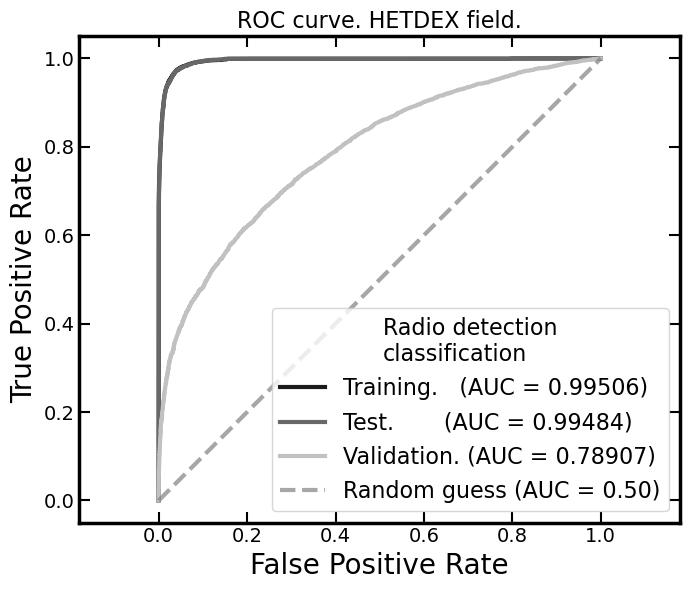

In [151]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
viz_test  = RocCurveDisplay(fpr=fpr_test,  tpr=tpr_test,  roc_auc=roc_auc_test)
viz_val   = RocCurveDisplay(fpr=fpr_val,   tpr=tpr_val,   roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1, lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_val.plot(ax=ax1,   lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='Radio detection\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_radio_detect_02.pdf', bbox_inches='tight')
plt.show()